In [2]:
import keras
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np


import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [40]:
def readImageAsArray(imagePath):
    img = cv2.imread(test_img_path)
    return img

def showImage(imageArray):
    # plots image array as colored image 
    plt.imshow(cv2.cvtColor(imageArray, cv2.COLOR_BGR2RGB))

In [4]:
model = keras.models.load_model("model-save.h5", 
                                custom_objects={'bce_dice_loss': bce_dice_loss,
                                                'dice_coef': dice_coef,
                                               })

In [66]:
test_img_path = "data/test_images/061fd7a.jpg"

In [67]:
# imageAsArray = readImageAsArray(test_img_path)

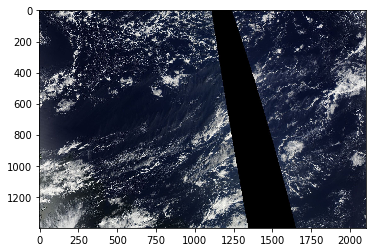

In [68]:
imageAsArray = readImageAsArray(test_img_path)

# imageAsArray
showImage(imageAsArray)

At this point, we have read an image, and we are able to view it and plot it


In [69]:

imageAsArrayCropped = cv2.resize(imageAsArray, (480, 320))   
imageAsArrayExpanded = np.expand_dims(imageAsArrayCropped, axis=0)
modelPrediction = model.predict(imageAsArrayExpanded)

# imageAsArray = cv2.resize(img, (480, 320))

# imageAsArray = np.expand_dims(imageAsArray, axis=0)
# # imagesArray = np.vstack([imageAsArray])

# test_prediction = model.predict(imagesArray)
# test_prediction
modelPrediction.shape

(1, 320, 480, 4)

In [70]:
modelPrediction[0][0][0]

array([0.42385054, 0.37570807, 0.44750783, 0.5495809 ], dtype=float32)

In [71]:
predictionMasks = modelPrediction[0, ].round().astype(int)
predictionRles = build_rles(predictionMasks, reshape=(350, 525))
# encodedPixels = pred_rles[3]

In [72]:
predictionMasks[0][0]
predictionMasks.shape
imageAsArrayCropped.shape

(320, 480, 3)

In [73]:
# plt.imshow(predictionMasks)
predictionMasks.shape
# for row in range(320):
#     for col in range(480):
#         print(predictionMasks[row][col])

(320, 480, 4)

In [74]:
import copy
maskedImage = copy.deepcopy(imageAsArrayCropped)
print(maskedImage.shape)

for row in range(320):
    for col in range(480):
        if(predictionMasks[row][col][0]==1):
            maskedImage[row][col] = [255,0,0]
        elif(predictionMasks[row][col][1]==1):
            maskedImage[row][col] = [0,255,0]
        elif(predictionMasks[row][col][2]==1):
            maskedImage[row][col] = [0,0,255]
        elif(predictionMasks[row][col][3]==1):
            maskedImage[row][col] = [100,100,100]
        else:
            maskedImage[row][col] = [0,0,0]

(320, 480, 3)


In [75]:
print(imageAsArrayCropped[0][0])

[40 20 18]


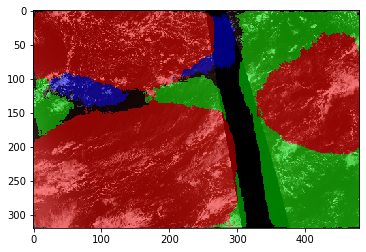

In [78]:
plt.imshow(imageAsArrayCropped, cmap='gray')
plt.imshow(maskedImage, cmap='gist_rainbow_r', alpha=0.5)
plt.savefig('segmentaed-cloud.jpeg')

In [16]:
len(predictionRles)

4

In [17]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


In [ ]:
fig = plt.figure(figsize=(480, 320))
plt.imshow(imageAsArrayCropped)
mask_rle = predictionRles
try: # label might not be there!
    mask = rle_decode(mask_rle)
except:
    mask = np.zeros((320, 480))
plt.imshow(mask, alpha=0.5, cmap='gray')

In [43]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
    return rles
        

In [ ]:
## run length encoding to image masks
def rle_to_mask(rle_string, imageAsArray):
    
    imageCopy = copy.deepcopy(imageAsArray)
    rows, cols = imageCopy.shape[0], imageCopy.shape[1]
    img = np.zeros(rows*cols, dtype=np.uint8)

    rle_numbers = [int(x) for x in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)

    for index, length in rle_pairs:
        index -= 1
        imageCopy[index:index+length] = 255
    imageCopy = imageCopy.reshape(cols,rows)
    imageCopy = imageCopy.T
    imageCopy = np.expand_dims(img, axis=2)
    
    return imageCopy


def ignore_background(img_mask, img_origin):
    assert img_mask.shape == img_mask.shape
    
    result = img_mask.copy()
    result[np.where(img_mask==255)] = img_origin[np.where(img_mask==255)]
    
    return result

In [ ]:
import copy
imageCopy = copy.deepcopy(imageAsArrayCropped)

In [ ]:
masks = rle_to_mask(predictionRles[0], imageCopy)
masks.shape
# showImage(masks)

In [ ]:
from fastai.vision import *

In [ ]:
fastMask = open_mask_rle(predictionMasks, shape=(320, 480))
fastMask

In [ ]:
img = imageAsArrayCropped
r = predictionMasks[0]
masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)

if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)